In [213]:
import shutil
import torch
import os

import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import albumentations as A
import pandas as pd
import numpy as np

from albumentations.pytorch.transforms import ToTensorV2
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import DatasetFolder
from tqdm import tqdm; tqdm.pandas();

In [214]:
# Устройство для обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

Current device: cuda


# Настройка параметров

In [215]:
# Директории с файлами
DATASET_DIR = './train_landmark_files'
CLASSES_DIR = './Dataset'

# Параметры загрузчиков
BACTH_SIZE  = 1
NUM_WORKERS = 0
PIN_MEMORY  = True

# Параметры оптимизатора
WEIGHT_DECAY  = 5e-5
LEARNING_RATE = 5e-3

MEAN = [0.3395, 0.3431, 0.3020]
STD  = [0.3908, 0.3897, 0.3542]

# Параметры планировщика
FACTOR    = 0.1
PATIENCE  = 10
THRESHOLD = 1e-4

# Параметры модели
ENCODER         = 'resnet50'
ENCODER_WEIGHTS = None

# Параметры обучения
NUM_EPOCHS = 30

# Параметры датасета
ORIGINAL_SIZE = 1500
PADED_SIZE    = 1536
PATCH_SIZE    = 256 
VALID_PART = 0.1
TEST_PART  = 0.1

# Настройка аугментаций

In [216]:
train_transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit = 0.1, contrast_limit = 0.1, p = 0.5),
        A.HorizontalFlip(p = 0.5),
        A.PadIfNeeded(PADED_SIZE, PADED_SIZE, border_mode = 0),
        A.Normalize(mean = MEAN, std = STD),        
        ToTensorV2()])

val_test_transform = A.Compose([
    A.PadIfNeeded(PADED_SIZE, PADED_SIZE, border_mode = 0),
    A.Normalize(mean = MEAN, std = STD),
    ToTensorV2()])

# Распределение файлов по классам

In [217]:
df = pd.read_csv('./train.csv')
df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [218]:
def path_handle(path, sign):

    if not os.path.exists(os.path.join(CLASSES_DIR, sign)):        
        os.mkdir(os.path.join(CLASSES_DIR, sign))

    shutil.move(path, os.path.join(CLASSES_DIR, sign))

In [219]:
if not os.path.exists(CLASSES_DIR):
    os.mkdir(CLASSES_DIR)

    [path_handle(path, sign) for path, _, _, sign in zip(df['path'], df['participant_id'], df['sequence_id'], df['sign'])]

# Разделение датасета

In [249]:
dataset = DatasetFolder(CLASSES_DIR, loader = lambda path: pq.read_table(path).to_pandas().dropna(), is_valid_file = lambda _: True)

n_val   = int(len(dataset) * VALID_PART)
n_test  = int(len(dataset) * TEST_PART)
n_train = len(dataset) - n_val - n_test

train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train, n_val, n_test])

# Создание загрузчиков

In [255]:
train_loader = DataLoader(train_dataset, batch_size = BACTH_SIZE, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)
val_loader   = DataLoader(val_dataset, batch_size = BACTH_SIZE, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)
test_loader  = DataLoader(test_dataset, batch_size = BACTH_SIZE, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.533508,0.432874,-0.043728
1,20,20-face-1,face,1,0.524704,0.397327,-0.074473
2,20,20-face-2,face,2,0.528149,0.409442,-0.040752
3,20,20-face-3,face,3,0.513380,0.363337,-0.051348
4,20,20-face-4,face,4,0.523715,0.386477,-0.078533
...,...,...,...,...,...,...,...
8683,35,35-right_hand-16,right_hand,16,0.551596,0.609307,-0.061677
8684,35,35-right_hand-17,right_hand,17,0.474747,0.568337,-0.076824
8685,35,35-right_hand-18,right_hand,18,0.559052,0.583239,-0.086096
8686,35,35-right_hand-19,right_hand,19,0.562447,0.610933,-0.074499


# Распределение классов в датасете

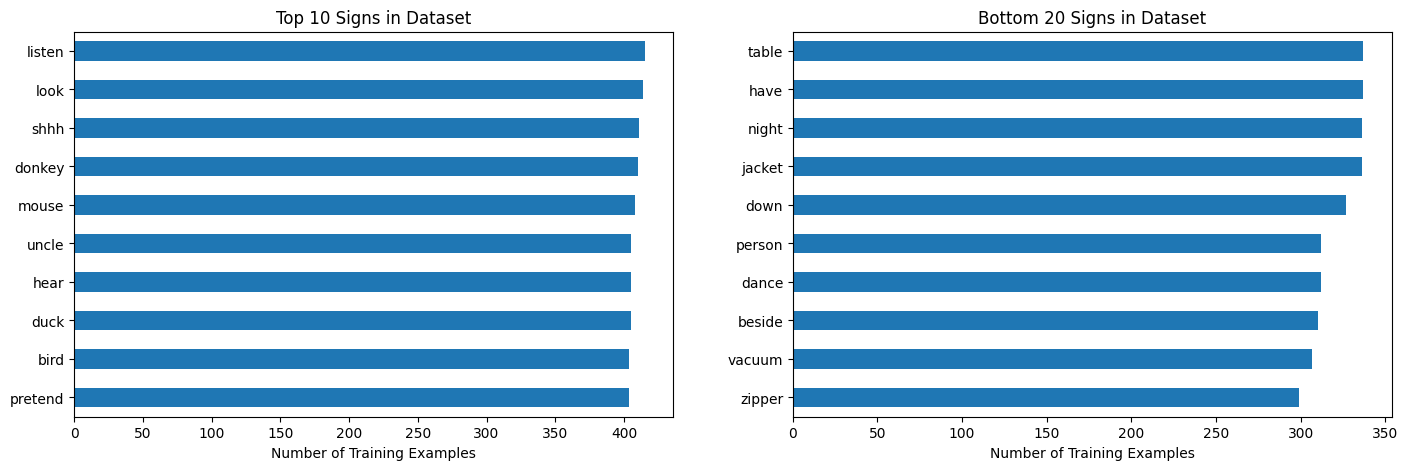

In [222]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17, 5))

df['sign'].value_counts().head(10).sort_values(ascending = True).plot(
    kind = "barh", ax = ax1, title = 'Top 10 Signs in Dataset'
)

df['sign'].value_counts().tail(10).sort_values(ascending = True).plot(
    kind = "barh", ax = ax2, title = 'Bottom 20 Signs in Dataset'
)

ax1.set_xlabel('Number of Training Examples')
ax2.set_xlabel('Number of Training Examples')

plt.show()

# Визуализация данных